# **Variational Autoencoder for molecular design**

One of the initial proposals to generate molecules using machine learning consisted on employing the concept of [_Variational Autoencoders_](https://arxiv.org/pdf/1312.6114.pdf). These models employ an "hourglass" architecture, creating an _information bottleneck_ that serves as latent representation of complex data instances (_e.g._ molecules given as SMILES or with other encoding).

<center>
<img src="https://drive.google.com/uc?id=1-fC0z4n-8Zim6e2XIp4Ggn3aowcLDI84" width = "60%">
</center>

In order to produce this latent representation, these models consist of two main parts: an **encoder**, which takes as input the initial representation of the desired data (_e.g._ a one-hot encoding of the molecules in the database) and outputs a vector of much smaller dimension that will play the role of the latent representation. After the encoder runs, the **decoder** takes the latent representation and tries to recompose the original input that the encoder received. The whole process is scored in terms of a reconstruction error function, that takes lower values the better the reconstruction for the inputs is. In this particular instance, it means that the model learns to encode and decode molecules to and from a much smaller latent space. 

Taking these previous ideas, the [original version of this method](https://pubs.acs.org/doi/full/10.1021/acscentsci.7b00572) includes also a **property predictor** that runs from the latent space representation of molecules: once a molecule is encoded into the latent space, its latent representation is fed to an extra model (a neural network) to try to predict the desired tardet function value. This extra network is trained using previously available data, on which each molecule is associated to a measured value of the target property. 

<center>
<img src = 'https://drive.google.com/uc?id=1jBNWRfqdXGOv4cPLL0J1NX1ldOj8egGf' width = "70%">
</center>

With all these components, the authors propose to navigate the latent space to look for molecules that may achieve a better outcome in the target property. In this step they make use of a _Bayesian optimization_ approach to try to find a solution that achieves the highest performance possible in a limited number of steps (since validating each proposal would entail producing a compound and measuring it in a laboratory, which is a costly process). 


In [1]:
# Mount folder
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
# Create links and set paths
repsol_path = '/content/repsol-ml4md'
your_path = '/content/drive/MyDrive/Proyectos/repsol-ml4md/generative_models/variational_autoencoder'
os.symlink(your_path, repsol_path) # Set here the path to your directory

repsol_utils_path = '/content/repsol-ml4md/utils'
sys.path.insert(0,repsol_utils_path)

main_dir = './repsol-ml4md/'
data_dir = f'{main_dir}data/'
data_path = f'{data_dir}processed.zip'
utils_dir = f'{main_dir}utils/'

In [3]:
# Install rdkit for molecule visualization
%pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 32.5 MB/s eta 0:00:00


In [4]:
# Torch for the heavy-duty calculations
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Other packages
import gzip
import zipfile
import pandas
import numpy as np
import argparse
import os
import h5py
import torch.optim as optim
from sklearn import model_selection

# Support 
import mol_utils as mu
import json
from collections import OrderedDict
import yaml
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import AllChem, Draw

We will define several functions to move around the model. We need these to load the data, convert to (and from) one-hot encoding, etc.

In [5]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    # print(vec)
    # print(charset)
    return "".join(map(lambda x: charset[x], vec)).strip()


def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    # charset =  h5f['charset'][:]
    charset = [x.decode() for x in h5f['charset']]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)


Declare the path to the file containing all hyperparameters and load them

In [6]:
param_path = f'{utils_dir}exp.json'
hyper_p = json.loads(open(param_path).read(), object_pairs_hook=OrderedDict)

Load the characters available in our database

In [8]:
charset_path = f'{utils_dir}zinc.json' 
charset = yaml.safe_load(open(charset_path)) # Load the characters present in the "zinc.json" file
char_indices = dict((c, i) for i, c in enumerate(charset))
print(charset)

['7', '6', 'o', ']', '3', 's', '(', '-', 'S', '/', 'B', '4', '[', ')', '#', 'I', 'l', 'O', 'H', 'c', '1', '@', '=', 'n', 'P', '8', 'C', '2', 'F', '5', 'r', 'N', '+', '\\', ' ']


Extract data files (_this may take a minute..._)

In [9]:
zip_ref = zipfile.ZipFile(data_path, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

## Declare the model

In this step of the process we define the complete network we will use to encode and decode molecules. This is a basic setup just to show the type of calculations that need to be done to implement the VAE. Since this is a simplified example, _this code does not include the property prediction module_, and thus would need certain extensions to represent the complete original model. This restriction is mostly based on the fact that the original setup can only be run using `tensorflow 1.x`, which is not supported by Collab anymore. Thus, this version is implemented in PyTorch, and is a simpler version of the original setup.

In [10]:
class MolecularVAE(nn.Module):

    def __init__(self):
        super(MolecularVAE, self).__init__()

        # Initialize the layer structure for the model

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        
        self.linear_0 = nn.Linear(70, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 33)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    # Encoder: Takes the input (one-hot) and encodes it to the latent space
    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    # Sampler: Takes samples from the latent space using a given mean and variance
    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    # Decoder: Takes samples from the latent space and outputs the decoded values
    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    # Full run: Passes an example through the whole system
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

The model here is a simple version of the original implementation. The code here describes a basic version for a Variational Autoencoder using 1D-convolutional layers for the encoding and a GRU layer for the decoding, plus additional linear layers and an extra function for the latent-space sampling   

We define here the objective function to train the model. It is a combination between the **cross-entropy** loss function and the **KL divergence**, that measures dissimilarity between distributions, which in this context ensures certain structure in the latent space.

$$ 
Loss = CE + KL
$$

The _cross-entropy_ let us know when the reconstruction of the molecule was successful or not. Thus, we use a binary cross-entropy of the form

$$
CE(\mathbf{x},\mathbf{\hat{x}}) = - \sum_i^N p(x_i) \log p(\hat{x}_i)
$$

with $\mathbf{x}$ and $\mathbf{\hat{x}}$ the input and the output from the encoder (_i.e._ the original molecule and the reconstruction) and $p$ the probabilities for the given character in each case (for $\mathbf{x}$, it is a one-hot encoding of the characters). Intuitively, the CE measures how well the molecule is reconstructed character-wise from the original molecule SMILES.

The KL divergence measures the dissimilarity between the latent space distribution and the imposed normal restrictions. This is induced by the latent variable model ([more details](https://arxiv.org/pdf/1312.6114.pdf))
$$
KL= \sum_{i=1}^n \sigma_i^2 + \mu_i^2 - log(\sigma_i)-1
$$

In [11]:
# Define the reconstruction loss for the VAE
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

Let us define some parameters for the run

In [12]:
epochs = 1 # 30 # 30 is a reccommended amount of epochs, but we will only do a small test here today
batch_size = 250
torch_seed = 123

torch.manual_seed(torch_seed)

# Device (prepared for CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The data has been already pre-processed and turned into one-hot encodings to ease the use. We will import it and load it directly using `torch` functions.

In [13]:
# Load the data from the processed dataset
data_train, data_test, charset = load_dataset(f'{data_dir}processed.h5')
data_train = data_train[1:1000]  # Subset, the training procedure is quite expensive and Collab does not support it

# Torch functions to load the data, batch-wise
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle=True)

Call the model and declare the optimizer, passing the parameters to be tuned.

In [14]:
# Load the model and the optimizer
vae = MolecularVAE().to(device)
optimizer = optim.Adam(vae.parameters())

To make the procedure more transparent, we will explicitly define the training function below.

In [15]:
# Define the training function
def train(epoch, model):

    model.train()
    train_loss = 0

    # Batch training
    for batch_idx, data in enumerate(train_loader):
        
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)
        
        # Print initial state of the model
        if batch_idx==0:
              inp = data.cpu().numpy()
              outp = output.cpu().detach().numpy()
              lab = data.cpu().numpy()
        
              print("Input:")
              print(decode_smiles_from_indexes(tuple(map(from_one_hot_array, inp[0])), charset))
        
              print("Label:")
              print(decode_smiles_from_indexes(tuple(map(from_one_hot_array, lab[0])), charset))
        
              sampled = outp[0].reshape(1, 120, len(charset)).argmax(axis=2)[0]
              print("Output:")
              print(decode_smiles_from_indexes(sampled, charset))
        
        # Evaluate the loss function and optimize
        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()

        # Print info every certain number of batches
        if batch_idx % 1 == 0:
              print('Epoch: ' +  str(epoch) + ', batch: ', str(batch_idx))
              print('Loss: ' + str(loss))

    print('train', train_loss / len(train_loader.dataset))
    return train_loss / len(train_loader.dataset)

Finally, we can _train the model here_. However, keep in mind that this is quite expensive and is unmanageable in basic versions of Collab (even using a small subset of the data for 1 epoch, it takes a while...)

In [16]:
# Train the model (careful, this can be expensive)
for epoch in range(1, epochs + 1):
    train_loss = train(epoch, vae)

Input:
c1ccc(cc1)c2nnc3n2-c4ccccc4SC3
Label:
c1ccc(cc1)c2nnc3n2-c4ccccc4SC3
Output:
6666llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, batch:  0
Loss: tensor(134093.2812, grad_fn=<AddBackward0>)
Epoch: 1, batch:  1
Loss: tensor(118497.4922, grad_fn=<AddBackward0>)
Epoch: 1, batch:  2
Loss: tensor(67839.4766, grad_fn=<AddBackward0>)
Epoch: 1, batch:  3
Loss: tensor(111608.1094, grad_fn=<AddBackward0>)
train tensor(432.4709, grad_fn=<DivBackward0>)


Let us load a somewhat _more trained_ version of the model, that at least is capable of capturing some features about the molecules' SMILES (_e.g._ somewhat produce molecules of similar length). This version is still far from the converged model, needing much more training in order to produce valuable results. We have decided to not pursue further the training of this `torch` implementation of the model because it is quite less functional than the original `tensorflow` implementation. Thus, if you intend to use and explore this model, we encourage you to take a look at the [original code](https://github.com/aspuru-guzik-group/chemical_vae/tree/main).  

In [17]:
# torch.save(vae.state_dict(), f'{repsol_path}/data/model_example.pt')
model = MolecularVAE()
model.load_state_dict(torch.load(f'{repsol_path}/data/model_example.pt'))
model.eval()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=70, out_features=435, bias=True)
  (linear_1): Linear(in_features=435, out_features=292, bias=True)
  (linear_2): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=33, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

Run the code for the next batch of training data

In [18]:
example = next(iter(train_loader))[0]
example.shape

decoded_molecules = mu.hot_to_smiles(example, charset)

Plot one of the molecules from the database as an example

CC(=O)Nc1ccc(cc1)NC(=O)COc2ccccc2OC                                                                                     


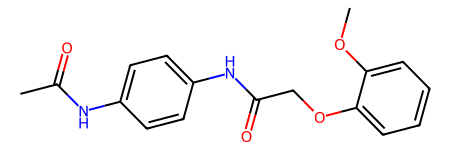

In [19]:
example_molecule = decoded_molecules[0]

print(decoded_molecules[0])
Chem.MolFromSmiles(example_molecule)

Set up the whole process: encode the example molecules, sample around them in the latent space and then decode the result.

In [20]:
z_mean, z_var = model.encode(example)
samples = model.sampling(z_mean, z_var)
x_example = model.decode(samples)

In [21]:
def one_hot_decode(vec, charset):
    vec_index = vec.argmax(axis=1)
    return "".join(map(lambda x: charset[x], vec_index)).strip()

def sample_molecules(model, base_molecules, num_per_molecule, charset = charset):
    model.eval()
    z_mean, z_var = model.encode(base_molecules)
    sampled_base_molecules = model.sampling(z_mean, z_var)
    encoded_base_molecules = model.decode(sampled_base_molecules)

    new_molecules = [ [] for _ in range(len(base_molecules))]

    with torch.no_grad():
        for i in range(num_per_molecule):
            output, mean, std = model.forward(encoded_base_molecules)
            for i, mol in enumerate(output):
                new_mol = one_hot_decode(mol, charset)
                new_molecules[i].append(new_mol)

    model.train()
    return encoded_base_molecules, new_molecules

Sample the molecules around each one of the last batch of molecules that we passed through the model. Once properly trained, the model will obtain `n` molecules that are located close to each one of those in the batch.  

In [22]:
enc, new_molecules = sample_molecules(model, example, 2) # The last input controls the number of molecules to be sampled

Character encoding using probabilities in the one-hot dictionary

In [23]:
enc[0]

tensor([[1.9584e-03, 6.6018e-04, 6.5636e-03,  ..., 6.1783e-03, 1.8086e-03,
         2.4926e-04],
        [1.2741e-03, 3.6815e-04, 1.0478e-02,  ..., 9.2551e-03, 1.9728e-03,
         1.1929e-04],
        [1.1370e-03, 3.2764e-04, 1.6108e-02,  ..., 1.1552e-02, 2.3908e-03,
         9.2381e-05],
        ...,
        [9.9976e-01, 4.4031e-06, 2.0160e-05,  ..., 2.6848e-06, 1.3694e-06,
         3.5976e-06],
        [9.9976e-01, 4.4015e-06, 2.0151e-05,  ..., 2.6835e-06, 1.3685e-06,
         3.5966e-06],
        [9.9976e-01, 4.4000e-06, 2.0141e-05,  ..., 2.6823e-06, 1.3676e-06,
         3.5957e-06]], grad_fn=<SelectBackward0>)

Show, for example, the two first molecules sampled from the encoding process (_this proves that the model needs much, much more training_)

In [24]:
new_molecules[0]

['Ccccccccccccccccccccccccccccccccccc', 'Ccccccccccccccccccccccccccccccccccc']

The complete procedure of the model is prepared so that, when coupled with the property prediction part, the model can start out in some point of the latent space corresponding to some molecule (_e.g._ ibuprofen) and then sample molecules increasingly different from the selected one, as can be seen in the figure:

<img src='https://drive.google.com/uc?id=1yyh1h9Ogj04-2o8g-EvnLtqPVKIEPWQM' width="70%">

Introducing the property prediction allows the model to _sort_ the latent space so that molecules with similar values for the desired property are located closely together. This leads to a structure similar to the following (real) examples from the original paper:

<img src='https://drive.google.com/uc?id=1AtI2d_kp1afsqTARrvusFKG_WGgVyi2f' width = "70%">

In order to optimize the property, we must navigate through the latent space to regions that entail an improvement on the values we are seeking.




> ### Final note:
> 
> The results from this model are, as can be expected due to the low level of training, quite bad. However, this is just an example for the more complete model, written in `tensorflow 1.x`. If you intend to use it, take a look at the [original repository](https://github.com/aspuru-guzik-group/chemical_vae), which is widely documented and quite simple to use (although you have to take care of all dependencies, of course).